# Appendix: helper functions

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display

Here we create some helper functions that will be used across notebooks using the magic `%%writefile`.

## Metrics

In [2]:
%%writefile ../skfin/metrics.py
import numpy as np


def test_monthly(df):
    return int(len(df) / len(df.asfreq("M"))) == 1


def test_bday(df):
    return int(len(df) / len(df.asfreq("B"))) == 1


def test_day(df):
    return int(len(df) / len(df.asfreq("D"))) == 1


def sharpe_ratio(df, num_period_per_year=None):
    num_period_per_year = None
    if test_monthly(df):
        num_period_per_year = 12
    if test_bday(df):
        num_period_per_year = 260
    if test_day(df):
        num_period_per_year = 365
    if num_period_per_year is None:
        return np.nan
    else:
        return df.mean() / df.std() * np.sqrt(num_period_per_year)


def drawdown(x, return_in_risk_unit=True, window=36, num_period_per_year=12):
    dd = x.cumsum().sub(x.cumsum().cummax())
    if return_in_risk_unit:
        return dd.div(x.rolling(window).std().mul(np.sqrt(num_period_per_year)))
    else:
        return dd

Overwriting ../skfin/metrics.py


## Data visualisation

Data exploration, in particular based on visualisation, is crucial to modern data science. `Pandas` has a lot of plotting functionalities (e.g. see the graph below), but we will find it usefull to use a custom `plot` set of functions.

In [3]:
%%writefile ../skfin/plot.py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skfin.metrics import sharpe_ratio

plt.style.use("seaborn-whitegrid")


def line(
    df,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    cumsum=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    legend_sharpe_ratio=None,
    legend=True,
    yscale=None,
    start_date=None,
):
    df = df.copy()
    if loc == "best":
        bbox_to_anchor = None
    if isinstance(df, dict):
        df = pd.concat(df, axis=1)
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if start_date is not None:
        df = df[start_date:]
    if cumsum & (legend_sharpe_ratio is None):
        legend_sharpe_ratio = True
    if legend_sharpe_ratio:
        df.columns = [f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]
    if cumsum:
        df = df.cumsum()
    if sort:
        df = df.loc[:, lambda x: x.iloc[-1].sort_values(ascending=False).index]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(df.index, df.values)
    if legend:
        ax.legend(df.columns, loc=loc, bbox_to_anchor=bbox_to_anchor)
    ax.set_title(title)
    if yscale == "log":
        ax.set_yscale("log")


def bar(
    df,
    err=None,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    horizontal=False,
    baseline=None,
    rotation=0,
):
    if isinstance(df, pd.DataFrame):
        df = df.squeeze()
    if isinstance(df, dict):
        df = pd.Series(df)
    if sort:
        df = df.sort_values()
    if err is not None:
        err = err.loc[df.index]
    labels = df.index
    x = np.arange(len(labels))
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if horizontal:
        ax.barh(x, df.values, xerr=err, capsize=5)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.barh(x, df_.values, color="lightgreen")
    else:
        ax.bar(x, df.values, yerr=err, capsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.bar(x, df_.values, color="lightgreen")
    ax.set_title(title)


def heatmap(
    df,
    ax=None,
    figsize=(8, 5),
    title="",
    vmin=None,
    vmax=None,
    vcompute=True,
    cmap="RdBu",
):
    labels_x = df.index
    x = np.arange(len(labels_x))
    labels_y = df.columns
    y = np.arange(len(labels_y))
    if vcompute:
        vmax = df.abs().max().max()
        vmin = -vmax
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    pos = ax.imshow(
        df.T.values, cmap=cmap, interpolation="nearest", vmax=vmax, vmin=vmin
    )
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(labels_x, rotation=90)
    ax.set_yticklabels(labels_y)
    ax.set_title(title)
    ax.grid(True)
    fig.colorbar(pos, ax=ax)


def scatter(
    df,
    xscale=None,
    yscale=None,
    xlabel=None,
    ylabel=None,
    xticks=None,
    yticks=None,
    figsize=(8, 5),
    title=None,
):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.scatter(df, df.index, facecolors="none", edgecolors="b", s=50)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xscale is not None:
        ax.set_xscale(xscale)
    if yscale is not None:
        ax.set_yscale(yscale)
    if yticks is not None:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    ax.set_title(title)

Overwriting ../skfin/plot.py


In [4]:
from skfin.plot import bar, line, heatmap

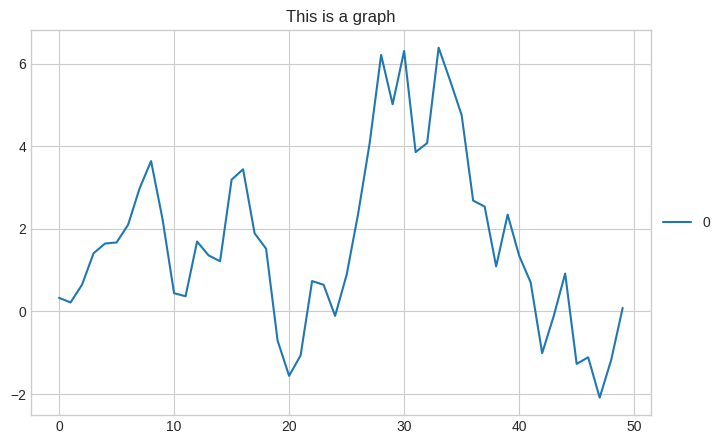

In [5]:
line(pd.Series(np.random.normal(size=50)), cumsum=True, title="This is a graph", 
     legend_sharpe_ratio=False)

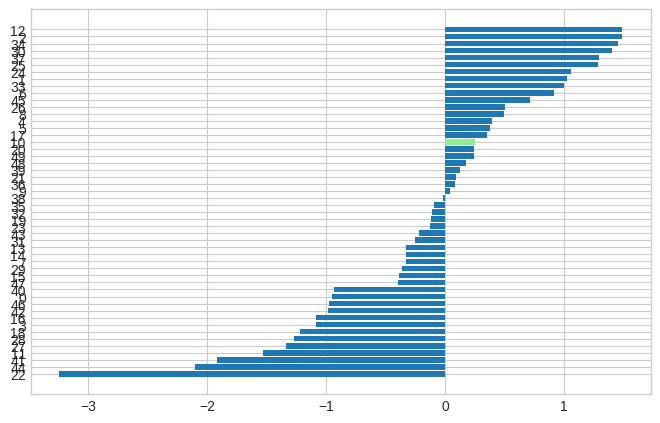

In [6]:
bar(pd.Series(np.random.normal(size=50)), baseline=10, horizontal=True)

## Mappings

In [7]:
%%writefile ../skfin/dataset_mappings.py
symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}

mapping_10X =   {'AAPL': ['APPLE COMPUTER INC', 'APPLE INC'],
             'AIG': 'AMERICAN INTERNATIONAL GROUP INC',
             'AMZN': 'AMAZON COM INC',
             'AXP': 'AMERICAN EXPRESS CO',
             'BA': 'BOEING CO',
             'BAC': 'BANK OF AMERICA CORP /DE/',
             'CAT': 'CATERPILLAR INC',
             'CL': 'COLGATE PALMOLIVE CO',
             'CMCSA': 'COMCAST CORP',
             'COP': 'CONOCOPHILLIPS',
             'CSCO': 'CISCO SYSTEMS INC',
             'CVC': 'CABLEVISION SYSTEMS CORP /NY',
             'CVS': ['CVS CORP', 'CVS/CAREMARK CORP', 'CVS CAREMARK CORP'],
             'CVX': ['CHEVRONTEXACO CORP', 'CHEVRON CORP'],
             'DD': 'DUPONT E I DE NEMOURS & CO',
             'DELL': ['DELL COMPUTER CORP', 'DELL INC'],
             'F': 'FORD MOTOR CO',
             'GD': 'GENERAL DYNAMICS CORP',
             'GE': 'GENERAL ELECTRIC CO',
             'GS': 'GOLDMAN SACHS GROUP INC/',
             'HD': 'HOME DEPOT INC',
             'HPQ': 'HEWLETT PACKARD CO',
             'IBM': 'INTERNATIONAL BUSINESS MACHINES CORP',
             'JPM': 'J P MORGAN CHASE & CO',
             'K': 'KELLOGG CO',
             'KMB': 'KIMBERLY CLARK CORP',
             'KO': 'COCA COLA CO',
             'MAR': 'MARRIOTT INTERNATIONAL INC /MD/',
             'MCD': 'MCDONALDS CORP',
             'MMM': '3M CO',
             'MSFT': 'MICROSOFT CORP',
             'NAV': 'NAVISTAR INTERNATIONAL CORP',
             'NOC': 'NORTHROP GRUMMAN CORP /DE/',
             'PEP': 'PEPSI BOTTLING GROUP INC',
             'PFE': 'PFIZER INC',
             'PG': 'PROCTER & GAMBLE CO',
             'R': 'RYDER SYSTEM INC',
             'RTN': 'RAYTHEON CO/',
             'TWX': ['AOL TIME WARNER INC', 'TIME WARNER INC'],
             'TXN': 'TEXAS INSTRUMENTS INC',
             'VLO': 'VALERO ENERGY CORP/TX',
             'WFC': 'WELLS FARGO & CO/MN',
             'WMT': 'WAL MART STORES INC',
             'XOM': 'EXXON MOBIL CORP',
             'XRX': 'XEROX CORP',
             'YHOO': 'YAHOO INC'}

Overwriting ../skfin/dataset_mappings.py


## Data utils

In [8]:
%%writefile ../skfin/data_utils.py
import os
from pathlib import Path

import pandas as pd


def clean_directory_path(cache_dir, default_dir="data"):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / default_dir
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
    if not cache_dir.is_dir():
        os.makedirs(cache_dir)
    return cache_dir


def save_dict(data, output_dir):
    assert isinstance(data, dict)
    if not output_dir.is_dir():
        os.mkdir(output_dir)
    for k, v in data.items():
        if isinstance(v, pd.DataFrame):
            v.to_parquet(output_dir / f"{k}.parquet")
        else:
            save_dict(v, output_dir=output_dir / k)


def load_dict(input_dir):
    data = {}
    for o in os.scandir(input_dir):
        if o.name.endswith(".parquet"):
            k = o.name.replace(".parquet", "")
            data[k] = pd.read_parquet(o)
        elif o.is_dir:
            data[o.name] = load_dict(o)
    return data

Overwriting ../skfin/data_utils.py
